In [12]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from cv2 import SIFT_create, imread, cvtColor, COLOR_BGR2GRAY, GaussianBlur
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from scripts.utils import extract_frames_info, label_keypoints, annotations_from_string

In [31]:
frames_info = extract_frames_info('data/train.csv', only_similar=True)

index = 0

image = imread(os.path.join("data", frames_info[index][0]))
cvtColor(image, COLOR_BGR2GRAY)
sift = SIFT_create()


In [32]:
kps, f = sift.detectAndCompute(image, None)
print(len(kps))

2637


In [33]:
labels = label_keypoints(kps, frames_info[index][1])

svm = SVC(C=3, gamma=.3).fit(f, labels)

In [34]:
pca = PCA(2)

reduced = pca.fit_transform(f)
print(pca.explained_variance_ratio_.sum())

0.20243722


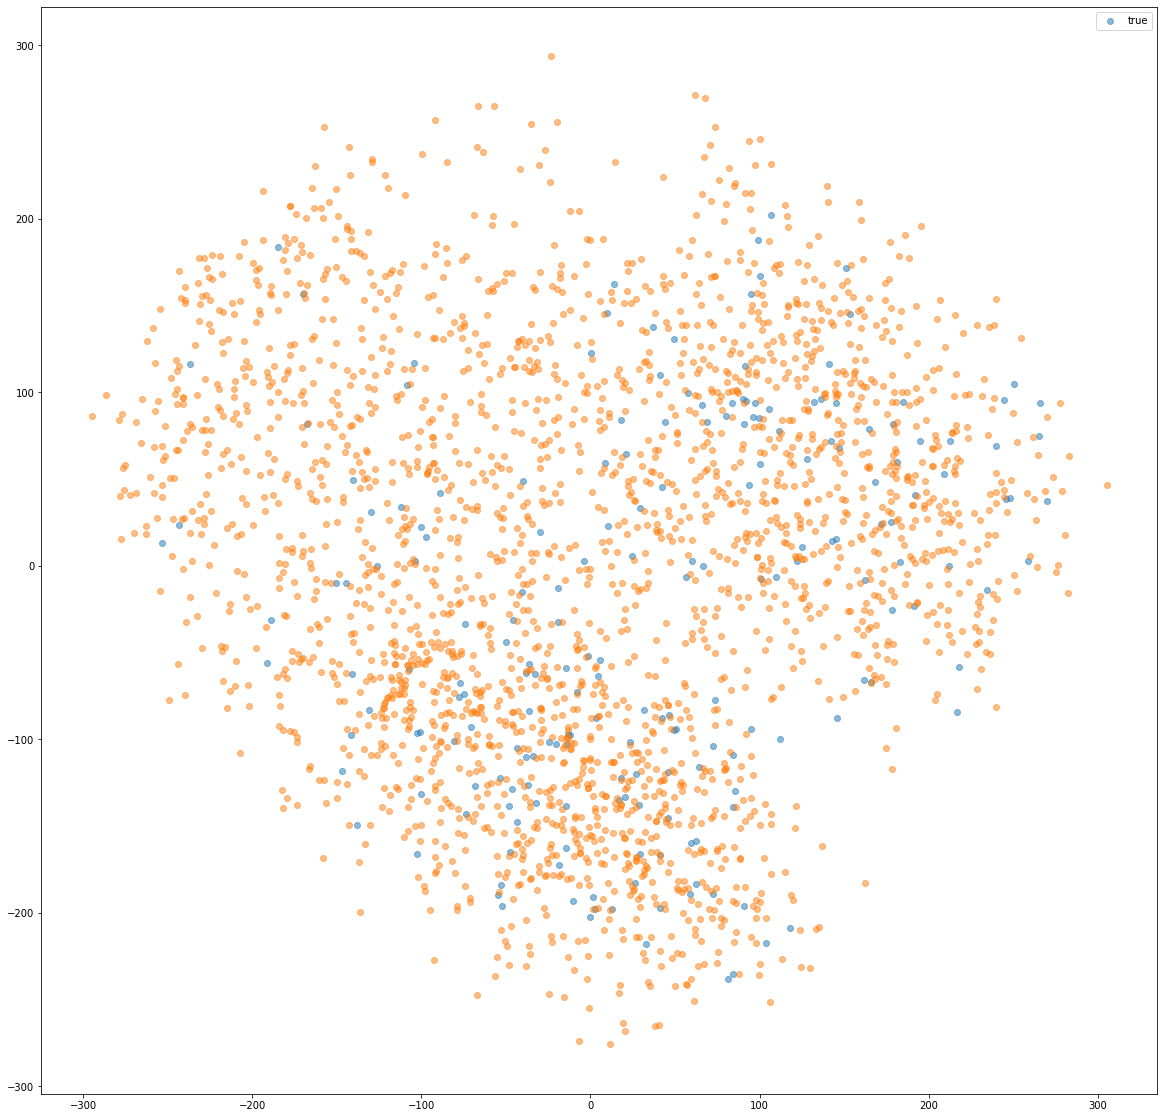

In [35]:
plt.figure(figsize=(20, 20))
plt.scatter(reduced[labels == 1][:, 0], reduced[labels == 1][:, 1], alpha=.5, label="true")
plt.scatter(reduced[labels == 0][:, 0], reduced[labels == 0][:, 1], alpha=.5)
plt.legend()

In [5]:
pred_labels = svm.predict(f)

In [6]:
confusion_matrix(labels, pred_labels)

array([[2436,    0],
       [   0,  201]], dtype=int64)

In [10]:
offset = 1

other_image = imread(os.path.join("data", frames_info[index + offset][0]))
other_kps, other_f = sift.detectAndCompute(other_image, None)
exp_labels = svm.predict(other_f)
real_labels = label_keypoints(other_kps, frames_info[index + offset][1])
confusion_matrix(real_labels, exp_labels)


array([[2269,    0],
       [ 233,    0]], dtype=int64)

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\Baptiste Prevot\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


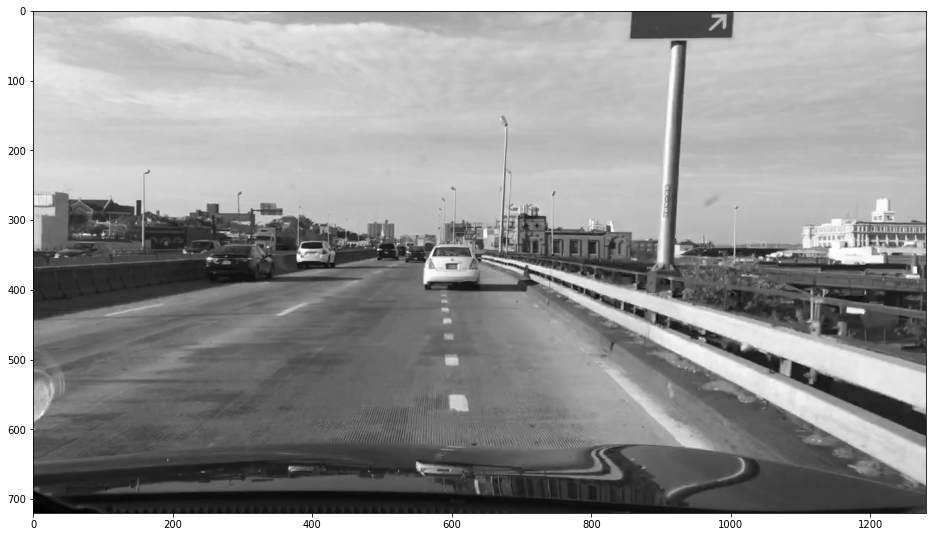

In [11]:
filter = exp_labels.astype(bool)
coords = np.array([kp.pt for kp in other_kps])
good_coords = coords[filter]

heatmap, xedges, yedges = np.histogram2d(good_coords[:, 0], good_coords[:, 1], bins=(200, 120))

heatmap = GaussianBlur(heatmap, [0, 0], 8)
heatmap = np.ma.masked_array(heatmap, heatmap < .01)

plt.figure(figsize=(16, 12))

plt.imshow(cvtColor(other_image, COLOR_BGR2GRAY), cmap="gray")
plt.pcolormesh(xedges, yedges, heatmap.T, alpha=.7)